## Introduction

Youtube is one of the most popular video sharing platform with more than 1 billion users. Users have long been outraged by the overwhelming number of spam messages in the comment section. In 2012 users created a petition asking Youtube to provide tools to deal with undesired content. In 2013, spam problem gets worse as Google overhauled the YouTube comment system to connect it to Google+, which allows users to post links. This attracts more malicious users to self-promote their videos using the platform. This project will build a spam filter to automatically filter spam comments.



## Data Wrangling

In this part we will:

    1: load the data into notebook
    2: check for any missing values

In [1]:

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as py
import seaborn as sns
import numpy as np
import glob 
import re

In [2]:
# import the files

path =r'./data/' 
allSongs = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_songs= []

for file in allSongs:
    frame = pd.read_csv(file)
    frame['song']=re.search(r"-(.*?).csv", file).group(1)
    list_songs.append(frame)
    
df = pd.concat(list_songs)
df.head()


COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
3          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
4          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
2  2013-11-08T17:34:21             just for test I have to say murdev.com   
3  2013-11-09T08:28:43   me shaking my sexy ass on my channel enjoy ^_^ Ôªø   
4  2013-11-10T16:05:38            watch?v=vtaRGgvGtWQ   Check this out .Ôªø   

   CLASS song  
0      1  Psy  
1      1  Psy  
2      1  Psy  
3      1  Psy  
4      1  Psy

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 6 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1711 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
song          1956 non-null object
dtypes: int64(1), object(5)
memory usage: 107.0+ KB


In [4]:
df['DATE']=df['DATE'].fillna(method='ffill')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 6 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1956 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
song          1956 non-null object
dtypes: int64(1), object(5)
memory usage: 107.0+ KB


In [5]:
df['DATE']=pd.to_datetime(df['DATE'])
df=df.set_index('DATE')
df.head()

COMMENT_ID  \
DATE                                                               
2013-11-07 06:20:48  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU   
2013-11-07 12:37:15  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A   
2013-11-08 17:34:21  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8   
2013-11-09 08:28:43          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   
2013-11-10 16:05:38          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw   

                               AUTHOR  \
DATE                                    
2013-11-07 06:20:48         Julius NM   
2013-11-07 12:37:15       adam riyati   
2013-11-08 17:34:21  Evgeny Murashkin   
2013-11-09 08:28:43   ElNino Melendez   
2013-11-10 16:05:38            GsMega   

                                                               CONTENT  CLASS  \
DATE                                                                            
2013-11-07 06:20:48  Huh, anyway check out this you[tube] channel: ...      1   
2013-11-07 12:37:15  Hey guys check out my new channel and our firs...      1   
2013-11-08 17:34:21             just for test I have to say murdev.com      1   
2013-11-09 08:28:43   me shaking my sexy ass on my channel enjoy ^_^ Ôªø      1   
2013-11-10 16:05:38            watch?v=vtaRGgvGtWQ   Check this out .Ôªø      1   

                    song  
DATE                      
2013-11-07 06:20:48  Psy  
2013-11-07 12:37:15  Psy  
2013-11-08 17:34:21  Psy  
2013-11-09 08:28:43  Psy  
2013-11-10 16:05:38  Psy

In [6]:
df.groupby('CLASS').size()

CLASS
0     951
1    1005
dtype: int64


There are total of 1956 comments in this data for the 5 most popular songs. 951 hams and 1005 spams. There are some missing values in the column of date, since the comments appear sequentially in time, we can use either forward fill or backward fill to estimate the time when that comment is made. The CLASS section is the label: 1 means spam and 0 means ham. 


## Data Analysis

We start the data analysis by asking some basic questions on the dataset:

    *is the average length of comment different among ham and spam?
    *can we identify some suspicious user account that seems relate to spam?
    *are spam comments more likely to have a URL in them?
    *does the spam comments have any correlation with time? (if it's fake account, maybe it's setup to send out spam comments periodically.)


In [7]:
# check the length of the comment.

# first expand contractions, so aren't will be are not so it's counted as two words.

import contractions

def contraction_expand(text):
    return contractions.fix(text)

df['CONTENT']=df['CONTENT'].apply(contraction_expand)

In [8]:

#calculate sentence length

df['length']=df['CONTENT'].apply(len)

df.groupby('CLASS')['length'].agg(['mean','std','min','max'])

mean         std  min   max
CLASS                                   
0       49.827550   56.526731    2   755
1      137.769154  159.459172   10  1200

Text(0,0.5,'counts')

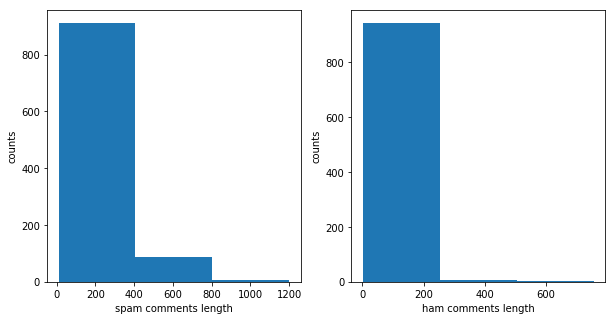

In [9]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(df[df['CLASS']==1].length,bins=3)
ax1.set_xlabel('spam comments length')
ax1.set_ylabel('counts')
ax2.hist(df[df['CLASS']==0].length,bins=3)
ax2.set_xlabel('ham comments length')
ax2.set_ylabel('counts')

The average length of spam vs ham comments are different. T- test shows that the mean comment length is significantly different. i.e. there is significant difference in the comment length b/t spam and ham group.

In [10]:
from scipy import stats

spam_len=df[df.CLASS==1].length.values
ham_len=df[df.CLASS==0].length.values
stats.ttest_ind(spam_len,ham_len,equal_var=False)

Ttest_indResult(statistic=16.426744907451987, pvalue=4.122869768320902e-55)

In [11]:
## check if there contains URL
## some Youtube URL format contains watch? 

def URL (string):
    pattern=r'(http[s]?://*)|(watch?)'
    return (bool(re.search(pattern,string)))

df['URL']=df['CONTENT'].apply(URL)
sum(df['URL'])/len(df['URL'])


0.14008179959100203

In [12]:

URL_dist=df.groupby('CLASS')['URL'].agg(sum)
URL_dist

CLASS
0     40.0
1    234.0
Name: URL, dtype: float64

about 14% of the comments contains URL, and most URLs are found in spam comments.

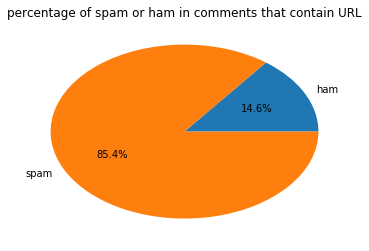

In [13]:
plt.pie(URL_dist/sum(URL_dist), labels=['ham','spam'],autopct='%1.1f%%')
plt.title('percentage of spam or ham in comments that contain URL')
py.savefig('URL.png')

In [14]:
spam_URL=df[df.CLASS==1].URL.values
ham_URL=df[df.CLASS==0].URL.values
stats.ttest_ind(spam_URL,ham_URL,equal_var=False)

Ttest_indResult(statistic=12.852571787339825, pvalue=6.927492725072384e-36)

the number of URLs in ham group is significantly different from the number of URLs in spam group.

In [15]:
# calculate percentage of capital letters in a comment

def capital_letters(string):
    return (len(re.findall('[A-Z]',string))/len(string))

df['capital']=df['CONTENT'].apply(capital_letters)
df['capital'].head()

DATE
2013-11-07 06:20:48    0.017857
2013-11-07 12:37:15    0.119760
2013-11-08 17:34:21    0.026316
2013-11-09 08:28:43    0.000000
2013-11-10 16:05:38    0.153846
Name: capital, dtype: float64

In [16]:
df.groupby('CLASS')['capital'].agg(['mean','std','min','max'])

mean       std  min       max
CLASS                                   
0      0.090289  0.161128  0.0  1.000000
1      0.108451  0.173301  0.0  0.919355

In [17]:
spam_C=df[df.CLASS==1].capital.values
ham_C=df[df.CLASS==0].capital.values
stats.ttest_ind(spam_C,ham_C,equal_var=False)

Ttest_indResult(statistic=2.4017292882621466, pvalue=0.016410664509908555)

The number of capital letters adjusted to comment length is significantly different in spam and ham group (assume 95% confidence).

In [18]:
df.groupby('CLASS')['AUTHOR'].value_counts()

CLASS  AUTHOR               
0      5000palo                 7
       Marshmallow Kingdom      3
       Seth Ryan                3
       Alain Bruno              2
       Athena Gomez             2
       BigBird Larry            2
       Brian Brai               2
       Chris Madzier            2
       D Maw                    2
       Eric Gonzalez            2
       Juan Martinez            2
       LaiLa Steudle            2
       LiveLikeLien x           2
       Naga Berapi              2
       Paul Crowder             2
       Pepe The Meme King       2
       Sonny Carter             2
       The Technology Zoo       2
       Warcorpse666             2
       janet rangel             2
       lol Ippocastano          2
       tyler sleetway           2
          Berty  Winata         1
       Aarjav Parmar            1
       Abdinasir Omar           1
       Abdou Abdou              1
       Abdullah Alawani         1
       Abhi Vats                1
       Abhishek Kum

We have 1793 unique user names in this dataset. There is a small fraction of users who make multiple comments but all of users who created spams only combment once. It's noticed that some spam accounts are from foreign countries (since their names are not English character). Next we will see how many foreign user names for spam and ham group.

In [19]:
# how many of non_english characters in the username

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
df['user_isEnglish']=df['AUTHOR'].apply(isEnglish)
df.groupby('CLASS')['user_isEnglish'].value_counts()

CLASS  user_isEnglish
0      True              901
       False              50
1      True              956
       False              49
Name: user_isEnglish, dtype: int64

In [20]:
spam_English=df[df.CLASS==1].user_isEnglish.values
ham_English=df[df.CLASS==0].user_isEnglish.values
stats.ttest_ind(spam_English,ham_English,equal_var=False)

Ttest_indResult(statistic=0.38464960723011715, pvalue=0.7005392401940488)

The number of foreign user names are not significantly different among ham/spam groups.

In [21]:
df[(df['CLASS']==1) & (df['user_isEnglish']==False)]['AUTHOR']

DATE
2014-11-03 21:38:17.000                              –ù–∏–∫–∏—Ç–∞ –ë–µ–∑—É—Ö–æ–≤
2014-11-03 22:22:14.000                            –ú–∏—Ö–∞–∏–ª –ü–∞–Ω–∫—Ä–∞—Ç–æ–≤
2014-11-03 23:29:00.000                                   –û–ª–µ–≥ –ü–∞—Å—å
2014-11-06 22:40:49.000                                 David Boƒçek
2014-11-07 12:08:13.000                              Uro≈° Slemenjak
2014-11-07 17:06:48.000                          O s√°bio das 7 eras
2014-11-13 07:59:33.000                           –ê–ª–µ–∫—Å–∞–Ω–¥—Ä –§–µ–¥–æ—Ä–æ–≤
2014-11-13 21:48:26.000                               Tofik Miedzy≈Ñ
2014-08-16 07:24:50.000                               Cl√©da Dimitri
2014-08-28 03:53:35.000                                  Mai Nguy·ªÖn
2014-09-10 01:50:55.000                                Nicol√°s Jara
2014-09-10 21:38:12.000                               M√§ttr Valleni
2014-10-03 15:28:05.000                     Mehmet Ertuƒürul Tohumcu
2014-10-24 09:55:30.000                          

There is not much suspecious account we can see by looking at ethenity groups from user names. 

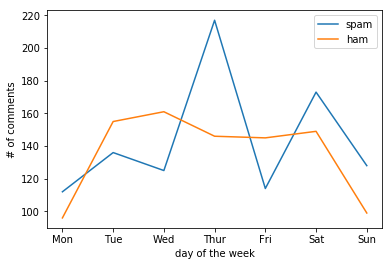

In [22]:

# explore the distribution of # of spam/ham among hours and day of week

spam=df[df['CLASS']==1]
ham=df[df['CLASS']==0]

spam_by_weekday=spam.groupby(spam.index.dayofweek).size()
ham_by_weekday=ham.groupby(ham.index.dayofweek).size()

spam_by_weekday.plot(label='spam')
ham_by_weekday.plot(label='ham')
plt.xticks(np.arange(7),('Mon','Tue','Wed','Thur','Fri','Sat','Sun'))
plt.xlabel('day of the week')
plt.ylabel('# of comments')
plt.legend(loc='upper right')
py.savefig('weekday_trend.png')

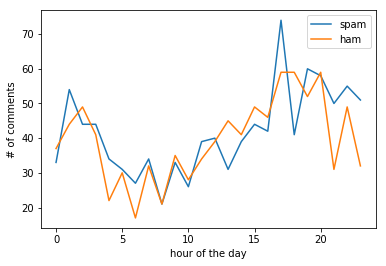

In [23]:
spam_by_hour=spam.groupby(spam.index.hour).size()
ham_by_hour=ham.groupby(ham.index.hour).size()

spam_by_hour.plot(label='spam')
ham_by_hour.plot(label='ham')
plt.xlabel('hour of the day')
plt.ylabel('# of comments')
plt.legend(loc='upper right')
py.savefig('hourly_trend.png')

These two graphs show interesting user behaviour. As we expected, users tend to make more comments in late afternoon throughout the night. We see most spam and ham comments are made b/t 5pm to 1 or 2am. Less comments are made on Sunday and Monday. Probably due to people are busy to start their new week (prep food for kids, run errands etc) and spend less time online. While ham comments are made evenly throughout the rest of week (Tuesday to Saturday), spam comments spike on Thursday and shows some zigzag behavior. There could be a lot of reasons. One explaination could be that spam accounts are programmed to send out spam comments periodically so they are more clustered around certain time.

In [24]:
df['Thursday']=df.index.dayofweek==3

spam_T=df[df.CLASS==1].Thursday.values
ham_T=df[df.CLASS==0].Thursday.values
stats.ttest_ind(spam_T,ham_T,equal_var=False)

Ttest_indResult(statistic=3.5704450654604205, pvalue=0.00036503763138973495)

Whether a comment is made on Thursday is a significant feature that is different in spam/ham group.

### Dimensionality reduction analysis

It will be interesting to see if there is any patterns in the ham/spam group. In this subsection, we will visualize the dataset in lower dimension using t-SNE. t-SNE a non-linear dimensionality reduction algorithm finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features. It's very computational demanding so we first use TruncatedSVD to reduce the feature dimensions. t-SNE recommends limit input size to 50 features, it's seen that after SVD we are able to retain 63% variance in the original data by limiting features to 50.

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fengyingdeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fengyingdeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
# data cleanning:
# Split into tokens.
# Convert to lowercase.
# Remove punctuation from each token.
# Filter out remaining tokens that are not alphabetic.
# Filter out tokens that are stop words.


def lemmatize_stem(word):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(word))

def preprocess (text):
    
    words=[w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops=[lemmatize_stem(t) for t in words if t not in stopwords.words('english')]
    
    return no_stops 

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

content=df['CONTENT']
vectorizer=TfidfVectorizer(tokenizer=preprocess,min_df=10)
bag_words=vectorizer.fit_transform(content)
print("number of features: {}".format(bag_words.shape[1]))



number of features: 234


0.6349016061647162


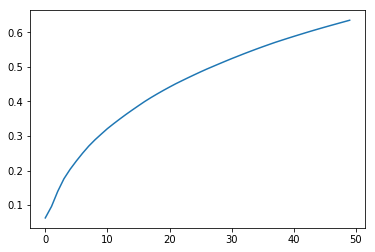

In [28]:
svd=TruncatedSVD(n_components=50,random_state=10)
X_transform=svd.fit_transform(bag_words)

CDF=np.cumsum(svd.explained_variance_ratio_)
plt.plot(CDF)
print(svd.explained_variance_ratio_.sum())

In [29]:
from sklearn.manifold import TSNE

model=TSNE(random_state=10)
transform=model.fit_transform(X_transform)


Text(0,0.5,'component_2')

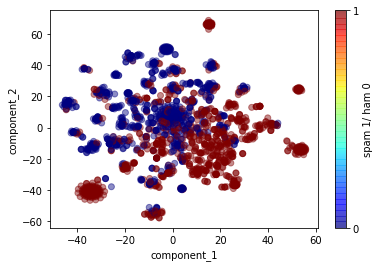

In [30]:
df_tsne=pd.DataFrame()
df_tsne['x']=transform[:,0]
df_tsne['y']=transform[:,1]
df_tsne['class']=df['CLASS'].values
plt.scatter(df_tsne.x,df_tsne.y,c=df_tsne['class'],cmap='jet',alpha=0.45)
plt.colorbar(label='spam 1/ ham 0', ticks=range(2))
plt.xlabel('component_1')
plt.ylabel('component_2')

The distance on the above figure shows how closely two docs are semantically. As we seen ham and spam comments are very similiar semantically.

Text(0.5,1,'ham')

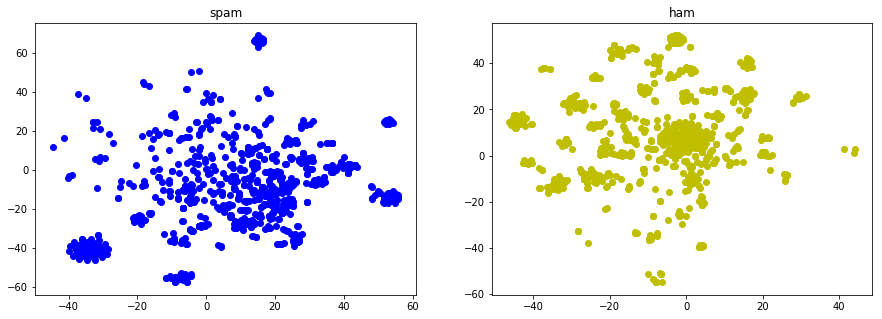

In [31]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(15,5))
ax1.scatter(df_tsne[df_tsne['class']==1].x,df_tsne[df_tsne['class']==1].y,c='b')
ax1.set_title('spam')
ax2.scatter(df_tsne[df_tsne['class']==0].x,df_tsne[df_tsne['class']==0].y,c='y')
ax2.set_title('ham')


### Next interesting quesition is: what are most important words in spam and ham group:

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=preprocess, min_df=10)
bag_words=vectorizer.fit_transform(content).toarray()

spam_bag_words=bag_words[df.CLASS==1]
spam_words=spam_bag_words.sum(axis=0)
idx = np.argsort(spam_words)[-10:]
top_10 = [word for word, num in vectorizer.vocabulary_.items() if num in idx]
print(top_10)

['br', 'amp', 'channel', 'check', 'http', 'like', 'subscrib', 'video', 'pleas', 'youtub']


In [33]:

ham_bag_words= bag_words[df.CLASS==0]
ham_words=ham_bag_words.sum(axis=0)
idx = np.argsort(ham_words)[-10:]
top_10 = [word for word, num in vectorizer.vocabulary_.items() if num in idx]
print(top_10)

['br', 'view', 'song', 'like', 'love', 'kati', 'best', 'video', 'perri', 'billion']


The most freq words in spam group relates to self-promoting videos with keywords like http, check and subscribe. The most freq words in ham group however are more relate to the song, some keywords relate to song's artist like kati perri. Some keywords describe the general feelings towards the song such as best, like, love.

In [34]:
# LDA analysis

from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics)
lda.fit(spam_bag_words)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)


/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topics found via LDA:

Topic #0:
br quot watch free follow http subscrib facebook million video

Topic #1:
subscrib pleas like channel music comment thank get u check

Topic #2:
amp make http money check today websit onlin eminem share

Topic #3:
check youtub video new channel playlist pleas best go call

Topic #4:
http guy check pleas visit make thank work hey like


In [35]:

lda = LDA(n_components=number_topics)
lda.fit(ham_bag_words)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topics found via LDA:

Topic #0:
kati perri song go girl roar hear part u http

Topic #1:
view billion video beauti nice youtub check see get megan

Topic #2:
like music year wow watch still fuck know one video

Topic #3:
song love br best shakira like waka make good ever

Topic #4:
world parti good rock million style would peopl eminem psi


## Machine learning

This section we explore different machine learning models for this classification problem.

1. Naive Bayes
2. Random Forest
3. Logistic Regression
4. SVM


In [36]:
# helper function to print out misclassification comments:

def miss_classification_print (pred_labels, test_labels, df):
    """this function is to print out some misclassificaiton examples"""
    """you need to provide: predict labels, the real labels, and the dataframe of the data"""
    
    ham=[]
    spam=[]
    for i in np.arange(df.shape[0]):
        if pred_labels[i] != test_labels[i]:
            if pred_labels [i] == 1:
                ham.append(df.iloc[i].CONTENT)
            if pred_labels [i]== 0:
                spam.append(df.iloc[i].CONTENT)
    print('ham messages that are misclassified as spam \n')
    for i in ham:
        print(i)
    print('\n')
    print('\n')
    print('spam messages that are misclassified as ham \n')
    for i in spam:
        print(i)


In [37]:
# let's try naive bayes as baseline.

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

X=df.drop(['CLASS'],axis=1)
y=df['CLASS']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=10)

# create bag of words
vec=TfidfVectorizer(min_df=3)
tfidf=vec.fit_transform(X_train['CONTENT'])
print("number of words before preprocessing: ", len(vec.get_feature_names()))

# define estimator
clf=MultinomialNB()

# define hypoparameters to tune
params_nb={'alpha': [0.00001,0.001, 0.1, 1, 10]}

grid_nb=GridSearchCV(estimator=clf, param_grid=params_nb,scoring='roc_auc',cv=10,n_jobs=-1)
grid_nb.fit(tfidf,y_train)
model_nb=grid_nb.best_estimator_
print("best alpha: ", grid_nb.best_params_)
print("best CV AUC: ",grid_nb.best_score_)

X_test_tfidf=vec.transform(X_test['CONTENT'])

number of words before preprocessing:  863
best alpha:  {'alpha': 1}
best CV AUC:  0.9792797615578425


In [38]:
# helper function to evaluate model across different threshold

from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

threshold=np.arange(0.1, 1, 0.1)

def model_evaluation (threshold, model, data, data_label):
    
    """In the spam filter application, we would rather have more false negatives than false positives,
    thus we can define a function to optimize. Here we use the F-beta score with beta of 0.5"""

    F_beta=[]
    
    # maximise F-beta score
    
    for t in threshold:
        print("\nthreshold is {}".format(t))
        p=model.predict_proba(data)
        predict_label=(p[:,1]>t).astype(int)
        
        score=fbeta_score(data_label,predict_label,beta=0.5)
        F_beta.append(score)
        print(confusion_matrix(data_label,predict_label),"\n")
        print('precision score is ', precision_score(data_label,predict_label))
        print('recall score is ',recall_score(data_label,predict_label))
        print('accuracy score is ',accuracy_score(data_label,predict_label))
        print('F_beta score is ',score)
        
    
    return F_beta

In [39]:
score_nb=model_evaluation(threshold,model_nb,tfidf,y_train)



threshold is 0.1
[[218 481]
 [  0 768]] 

precision score is  0.6148919135308246
recall score is  1.0
accuracy score is  0.6721199727334697
F_beta score is  0.6662040249826509

threshold is 0.2
[[440 259]
 [  4 764]] 

precision score is  0.7468230694037146
recall score is  0.9947916666666666
accuracy score is  0.8207225630538514
F_beta score is  0.786008230452675

threshold is 0.30000000000000004
[[571 128]
 [ 13 755]] 

precision score is  0.855039637599094
recall score is  0.9830729166666666
accuracy score is  0.9038854805725971
F_beta score is  0.8779069767441859

threshold is 0.4
[[620  79]
 [ 23 745]] 

precision score is  0.904126213592233
recall score is  0.9700520833333334
accuracy score is  0.9304703476482618
F_beta score is  0.9165846456692915

threshold is 0.5
[[651  48]
 [ 34 734]] 

precision score is  0.9386189258312021
recall score is  0.9557291666666666
accuracy score is  0.9441036128152692
F_beta score is  0.9419917864476386

threshold is 0.6
[[690   9]
 [ 59 709]] 


Text(0.5,1,'Naive Bayes performance')

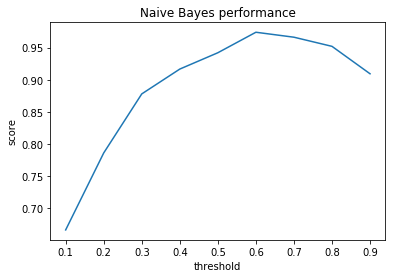

In [40]:
plt.plot(threshold,score_nb)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Naive Bayes performance')

From the above graph, best threshold is 0.6. Let's use this model on test data.

In [41]:
X_test_predict_prob=model_nb.predict_proba(X_test_tfidf)
X_test_predict_label=(X_test_predict_prob[:,1]>0.6).astype(int)

print("the confusion matrix: \n", confusion_matrix(y_test,X_test_predict_label))
print("the accuracy score is ", accuracy_score(y_test,X_test_predict_label))
print("f-beta score is ", fbeta_score(y_test,X_test_predict_label,beta=0.5))
print('precision score is ', precision_score(y_test,X_test_predict_label))
print('recall score is ',recall_score(y_test,X_test_predict_label))

the confusion matrix: 
 [[243   9]
 [ 17 220]]
the accuracy score is  0.9468302658486708
f-beta score is  0.9540329575021682
precision score is  0.9606986899563319
recall score is  0.9282700421940928


In [42]:
miss_classification_print(X_test_predict_label,y_test,X_test)

ham messages that are misclassified as spam 

If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.Ôªø
Loves itÔªø
On 0:02 you can see the camera man on his glasses....Ôªø
What&#39;s with the guys jacket? 1 sleeve and a sleeveless armÔªø
like meÔªø
Hii youtubeÔªø
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best partÔªø
My friend Sam loves this songüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäüòäÔªø
First they were fighting... Then they were making out...Ôªø




spam messages that are misclassified as ham 

Believe that Jesus Christ is your savior for all your sins. If you truly believe in Jesus Christ to be your savior for all your sins then you will go to Heaven. If you believe in Jesus Christ then you are saved and you are in salvati

In the above model evaluation analysis, I choose the F-beta score with beta=0.5. In this application, users will be outraged if their comments are misclassified as spam thus we want to minimize false positive. We would rather having more false negatives rather than having too much false positive. F-beta score with beta=0.5 will favor precision (thus less false positives).

No preprocessing is performed since I tested that preprocessing steps such as stop words removal or stemming hurt the performance. The accuracy score using pre-processed data is 0.83.

(I tested preprocessing steps: stop word removal, stem, min_df, punctuation removal, stem individually and found that both stem and punctuation removal hurt the performance of models, including naive bayes, random forest, and logistic regression)


In [43]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=10)

params_rf={'n_estimators': [50, 100, 200, 300]}

grid_rf=GridSearchCV(estimator=rf, param_grid=params_rf,scoring='roc_auc',cv=5,n_jobs=-1)
grid_rf.fit(tfidf,y_train)
model_rf=grid_rf.best_estimator_
print("best alpha: ", grid_rf.best_params_)
print("best CV AUC: ",grid_rf.best_score_)


best alpha:  {'n_estimators': 200}
best CV AUC:  0.9870869341553205


In [44]:
# choose the best threshold

score_rf=model_evaluation(threshold,model_rf,tfidf,y_train)



threshold is 0.1
[[598 101]
 [  2 766]] 

precision score is  0.8835063437139562
recall score is  0.9973958333333334
accuracy score is  0.9297886843899114
F_beta score is  0.9041548630783759

threshold is 0.2
[[685  14]
 [  2 766]] 

precision score is  0.982051282051282
recall score is  0.9973958333333334
accuracy score is  0.989093387866394
F_beta score is  0.9850823045267489

threshold is 0.30000000000000004
[[699   0]
 [  2 766]] 

precision score is  1.0
recall score is  0.9973958333333334
accuracy score is  0.9986366734832992
F_beta score is  0.9994780793319414

threshold is 0.4
[[699   0]
 [  2 766]] 

precision score is  1.0
recall score is  0.9973958333333334
accuracy score is  0.9986366734832992
F_beta score is  0.9994780793319414

threshold is 0.5
[[699   0]
 [  2 766]] 

precision score is  1.0
recall score is  0.9973958333333334
accuracy score is  0.9986366734832992
F_beta score is  0.9994780793319414

threshold is 0.6
[[699   0]
 [  2 766]] 

precision score is  1.0
reca

Text(0.5,1,'Random Forest performance')

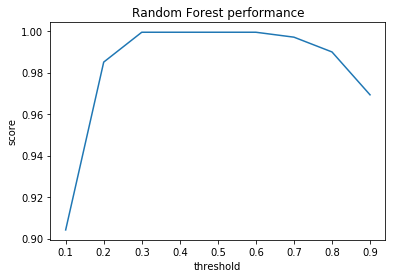

In [45]:
plt.plot(threshold,score_rf)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Random Forest performance')

From the above analysis, we can pick either 0.3,0.4, 0.5 or 0.6. Here I picked 0.5.

In [46]:
# evaluate on test data

X_test_predict_prob=model_rf.predict_proba(X_test_tfidf)
X_test_predict_label=(X_test_predict_prob[:,1]>0.5).astype(int)

print("the confusion matrix: \n", confusion_matrix(y_test,X_test_predict_label))
print("the accuracy score is ", accuracy_score(y_test,X_test_predict_label))
print("f-beta score is ", fbeta_score(y_test,X_test_predict_label,beta=0.5))
print('precision score is ', precision_score(y_test,X_test_predict_label))
print('recall score is ',recall_score(y_test,X_test_predict_label))

the confusion matrix: 
 [[246   6]
 [ 19 218]]
the accuracy score is  0.9488752556237219
f-beta score is  0.9620476610767873
precision score is  0.9732142857142857
recall score is  0.919831223628692


In [47]:
miss_classification_print(X_test_predict_label,y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happenÔªø
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.Ôªø
"....because I AM a champion...and you are going to hear me roar!"   Today I AM my own champion  Today I AM a champion for the Creator  Today I AM doing positive in my world Today I AM blessing and healing all around me Today I AM successful and  creating success  Ôªø
My honest opinion. it is a very mediocre song. Nothing unique or special  about her music, lyrics or voice. Nothing memorable like Billie Jean or  Beat It. Before her millions of fans reply with hate comments, i know this  is a democracy and people are free to see what they want. But then do not I  have the right to express my opinion? Please do not reply with dumb comments  lie "if you do not like it do not watch it". I 

In [48]:
# logistic regression
# Grid search to tune hypoparameters

from sklearn.linear_model import LogisticRegression

lg=LogisticRegression(random_state=10)

params_lg={'C': [0.1, 1, 10, 50, 100]}

grid_lg=GridSearchCV(estimator=lg, param_grid=params_lg,scoring='roc_auc',cv=5,n_jobs=-1)
grid_lg.fit(tfidf,y_train)
model_lg=grid_lg.best_estimator_
print("best alpha: ", grid_lg.best_params_)
print("best CV AUC: ",grid_lg.best_score_)


best alpha:  {'C': 10}
best CV AUC:  0.9904938304739861


In [49]:
# choose the best threshold

score_lg=model_evaluation(threshold,model_lg,tfidf,y_train)


threshold is 0.1
[[586 113]
 [  2 766]] 

precision score is  0.8714448236632537
recall score is  0.9973958333333334
accuracy score is  0.9216087252897068
F_beta score is  0.8940242763772175

threshold is 0.2
[[659  40]
 [  2 766]] 

precision score is  0.9503722084367245
recall score is  0.9973958333333334
accuracy score is  0.9713701431492843
F_beta score is  0.9594188376753507

threshold is 0.30000000000000004
[[681  18]
 [  2 766]] 

precision score is  0.9770408163265306
recall score is  0.9973958333333334
accuracy score is  0.9863667348329925
F_beta score is  0.9810450819672131

threshold is 0.4
[[690   9]
 [  4 764]] 

precision score is  0.9883570504527813
recall score is  0.9947916666666666
accuracy score is  0.9911383776414451
F_beta score is  0.9896373056994818

threshold is 0.5
[[696   3]
 [  5 763]] 

precision score is  0.9960835509138382
recall score is  0.9934895833333334
accuracy score is  0.994546693933197
F_beta score is  0.9955636743215031

threshold is 0.6
[[698  

Text(0.5,1,'Logistic Regression performance')

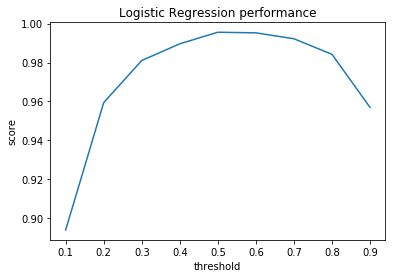

In [50]:
plt.plot(threshold,score_lg)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Logistic Regression performance')

From the above analysis, threshold =0.5 is the best.

In [51]:
# evaluate on test data

X_test_predict_prob=model_lg.predict_proba(X_test_tfidf)
X_test_predict_label=(X_test_predict_prob[:,1]>0.5).astype(int)

print("the confusion matrix: \n", confusion_matrix(y_test,X_test_predict_label))
print("the accuracy score is ", accuracy_score(y_test,X_test_predict_label))
print("f-beta score is ", fbeta_score(y_test,X_test_predict_label,beta=0.5))
print('precision score is ', precision_score(y_test,X_test_predict_label))
print('recall score is ',recall_score(y_test,X_test_predict_label))

the confusion matrix: 
 [[243   9]
 [ 12 225]]
the accuracy score is  0.9570552147239264
f-beta score is  0.959079283887468
precision score is  0.9615384615384616
recall score is  0.9493670886075949


In [52]:
miss_classification_print(X_test_predict_label,y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happenÔªø
sorry to all my haters<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />for party rock enÔªø
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.Ôªø
I found out this song nowÔªø
Loves itÔªø
On 0:02 you can see the camera man on his glasses....Ôªø
I do not even watch it anymore i just come here to check on 2 Billion or notÔªø
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best partÔªø
Thumbs up if you&#39;re watching in 2015Ôªø




spam messages that are misclassified as ham 

  Haha , Miley Cyrus has done it once again  Today someone leeched a porno video with her on a celeb site   I believe the website link is : miley-celeb-news.co.uk in case you want to view it.... 
EVERYBODY PLEASE V

In [53]:
# bag of words will create a lot of features and we know that SVM works good with high dimensions. 

from sklearn.svm import SVC

svc=SVC(probability=True)

params_svc={'C': [0.001, 0.1, 1, 10],
            'kernel':['linear', 'poly', 'rbf']}

grid_svc=GridSearchCV(estimator=svc, param_grid=params_svc,scoring='roc_auc',cv=5,n_jobs=-1)
grid_svc.fit(tfidf,y_train)
model_svc=grid_svc.best_estimator_
print("best alpha: ", grid_svc.best_params_)
print("best CV AUC: ",grid_svc.best_score_)


best alpha:  {'C': 1, 'kernel': 'linear'}
best CV AUC:  0.9892946773142651


In [54]:
# choose the best threshold

score_svc=model_evaluation(threshold,model_svc,tfidf,y_train)


threshold is 0.1
[[662  37]
 [  4 764]] 

precision score is  0.9538077403245943
recall score is  0.9947916666666666
accuracy score is  0.9720518064076347
F_beta score is  0.9617321248741189

threshold is 0.2
[[674  25]
 [  6 762]] 

precision score is  0.9682337992376112
recall score is  0.9921875
accuracy score is  0.9788684389911384
F_beta score is  0.9729315628192035

threshold is 0.30000000000000004
[[677  22]
 [  8 760]] 

precision score is  0.9718670076726342
recall score is  0.9895833333333334
accuracy score is  0.9795501022494888
F_beta score is  0.9753593429158111

threshold is 0.4
[[684  15]
 [ 11 757]] 

precision score is  0.9805699481865285
recall score is  0.9856770833333334
accuracy score is  0.9822767552828903
F_beta score is  0.9815871369294606

threshold is 0.5
[[688  11]
 [ 12 756]] 

precision score is  0.9856584093872229
recall score is  0.984375
accuracy score is  0.9843217450579413
F_beta score is  0.9854014598540146

threshold is 0.6
[[690   9]
 [ 17 751]] 



Text(0.5,1,'SVC performance')

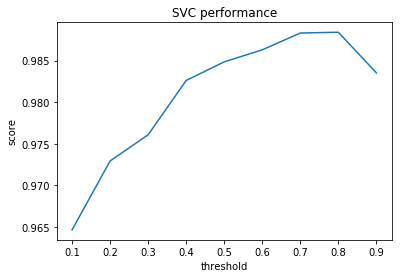

In [55]:
plt.plot(threshold,score_svc)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('SVC performance')

From above analysis, threshold=0.7 is a good choice. It minimizes the false positive without having too much false negatives.

In [58]:
# evaluate on test data

X_test_predict_prob=model_svc.predict_proba(X_test_tfidf)
X_test_predict_label=(X_test_predict_prob[:,1]>0.7).astype(int)

print("the confusion matrix: \n", confusion_matrix(y_test,X_test_predict_label))
print("the accuracy score is ", accuracy_score(y_test,X_test_predict_label))
print("f-beta score is ", fbeta_score(y_test,X_test_predict_label,beta=0.5))
print('precision score is ', precision_score(y_test,X_test_predict_label))
print('recall score is ',recall_score(y_test,X_test_predict_label))

the confusion matrix: 
 [[246   6]
 [ 16 221]]
the accuracy score is  0.9550102249488752
f-beta score is  0.9650655021834063
precision score is  0.973568281938326
recall score is  0.9324894514767933


In [59]:
miss_classification_print(X_test_predict_label,y_test,X_test)

ham messages that are misclassified as spam 

If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.Ôªø
Loves itÔªø
On 0:02 you can see the camera man on his glasses....Ôªø
I do not even watch it anymore i just come here to check on 2 Billion or notÔªø
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best partÔªø
Thumbs up if you&#39;re watching in 2015Ôªø




spam messages that are misclassified as ham 

‚ñë‚ñë‚ñë‚ñë‚ñë‚ñë‚ñë/\‚ñë‚ñë‚ñë‚ñë‚ñë‚ñÑ‚ñê<br />‚ñë‚ñë‚ñë‚ñë‚ñë‚ñë/ ¬† ¬† \‚ñë‚ñë‚ñë‚ñÑ‚ñà‚ñà‚ñÑ<br />‚ñë‚ñë‚ñë‚ñë‚ñë/ ¬†(o) ¬† \‚ñë‚ñë‚ñë‚ñë‚ñë‚ñÄ‚ñà‚ñÑ<br />‚ñë‚ñë‚ñë‚ñë/ ¬† ¬† ¬† ¬† ¬† ¬† \‚ñë‚ñë‚ñë‚ñë‚ñë‚ñë‚ñÄ‚ñà‚ñÑ<br />‚ñë‚ñë‚ñë/__ ¬† \ ¬† ‚ñë‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÄ‚ñÄ<br />‚ñë‚ñë‚ñë‚ñë‚ñÑ‚ñÑ‚ñÑ‚ñà‚ñà‚ñÄ‚ñÄ‚ñÄ‚ñÄ<br />‚ñë‚ñë‚ñë‚ñà‚ñÄ‚ñÑ‚ñÑ‚ñÑ‚ñà‚ñë‚ñÄ‚ñÄ ¬† ¬† ¬† YOU HAVE BEEN SPOOKED BY THE SPOOKINATI<br />‚ñë‚ñë‚ñë‚ñå‚ñë‚ñÑ‚ñÑ‚ñÑ‚ñê‚ñå‚ñÄ‚ñÄ‚ñÄ<br />‚ñÑ‚ñë‚ñê‚ñë‚ñë‚ñë‚

Generally speaking ways to improve model accuracy are:

 1. tune your classifier (adjusting the classifier's tunable paramaters);
 2. apply some sort of classifier combination technique (eg, ensembling, boosting, bagging); 
 3. look at the data fed to the classifier--either add more data, improve your basic parsing, or refine the features you select from the data.
 
In the last section we looked at option 1 and 2, where we tune each model parameters and tried ensemble method such as random forest. In the next section, we will explore adding more features and try ensemble methods to further improve model accuracy.

## Machine leanring -- more complex model

In [58]:
df.head()

COMMENT_ID  \
DATE                                                               
2013-11-07 06:20:48  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU   
2013-11-07 12:37:15  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A   
2013-11-08 17:34:21  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8   
2013-11-09 08:28:43          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   
2013-11-10 16:05:38          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw   

                               AUTHOR  \
DATE                                    
2013-11-07 06:20:48         Julius NM   
2013-11-07 12:37:15       adam riyati   
2013-11-08 17:34:21  Evgeny Murashkin   
2013-11-09 08:28:43   ElNino Melendez   
2013-11-10 16:05:38            GsMega   

                                                               CONTENT  CLASS  \
DATE                                                                            
2013-11-07 06:20:48  Huh, anyway check out this you[tube] channel: ...      1   
2013-11-07 12:37:15  Hey guys check out my new channel and our firs...      1   
2013-11-08 17:34:21             just for test I have to say murdev.com      1   
2013-11-09 08:28:43   me shaking my sexy ass on my channel enjoy ^_^ Ôªø      1   
2013-11-10 16:05:38            watch?v=vtaRGgvGtWQ   Check this out .Ôªø      1   

                    song  length    URL   capital  user_isEnglish  Thursday  
DATE                                                                         
2013-11-07 06:20:48  Psy      56  False  0.017857            True      True  
2013-11-07 12:37:15  Psy     167  False  0.119760            True      True  
2013-11-08 17:34:21  Psy      38  False  0.026316            True     False  
2013-11-09 08:28:43  Psy      48  False  0.000000            True     False  
2013-11-10 16:05:38  Psy      39   True  0.153846            True     False

### Concatenate bag of words with features we explore in the EDA that differentiate two groups:
1. comment length
2. the percentage of capital words
3. whether the comment is made on Thursday

From the last section we've seen that SVM performs better on test data. So we will use SVM on concat features to see if it improves further.

In [59]:
from sklearn.preprocessing import MinMaxScaler

X_train['URL']=X_train['URL'].astype(int)
X_train['Thursday']=X_train['Thursday'].astype(int)
features=X_train[['URL','length','capital','Thursday']]
scaler=MinMaxScaler()
features_norm=scaler.fit_transform(features)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [60]:
tfidf_dense=tfidf.toarray()
feature_new=np.concatenate((tfidf_dense,features_norm),axis=1)

In [61]:
# calculate new feature matrix for test data.

X_test['URL']=X_test['URL'].astype(int)
X_test['Thursday']=X_test['Thursday'].astype(int)
features_test=X_test[['URL','length','capital','Thursday']]
scaler_test=MinMaxScaler()
features_norm_test=scaler_test.fit_transform(features_test)
X_test_feature=np.concatenate((X_test_tfidf.toarray(),features_norm_test),axis=1)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [62]:


svc=SVC(probability=True)

params_svc={'C': [0.001, 0.1, 1, 10],
            'kernel':['linear', 'poly', 'rbf']}

grid_svc=GridSearchCV(estimator=svc, param_grid=params_svc,scoring='roc_auc',cv=5,n_jobs=-1)
grid_svc.fit(feature_new,y_train)
model_svc_concat=grid_svc.best_estimator_
print("best alpha: ", grid_svc.best_params_)
print("best CV AUC: ",grid_svc.best_score_)


best alpha:  {'kernel': 'linear', 'C': 1}
best CV AUC:  0.9890332485178729


In [63]:
# choose the best threshold

score_svc=model_evaluation(threshold,model_svc_concat,feature_new,y_train)


threshold is 0.1
[[656  43]
 [  4 764]] 

precision score is  0.9467162329615861
recall score is  0.9947916666666666
accuracy score is  0.9679618268575324
F_beta score is  0.9559559559559561

threshold is 0.2
[[677  22]
 [  6 762]] 

precision score is  0.9719387755102041
recall score is  0.9921875
accuracy score is  0.9809134287661895
F_beta score is  0.975922131147541

threshold is 0.30000000000000004
[[683  16]
 [  9 759]] 

precision score is  0.9793548387096774
recall score is  0.98828125
accuracy score is  0.9829584185412407
F_beta score is  0.9811271975180971

threshold is 0.4
[[687  12]
 [ 12 756]] 

precision score is  0.984375
recall score is  0.984375
accuracy score is  0.983640081799591
F_beta score is  0.984375

threshold is 0.5
[[689  10]
 [ 16 752]] 

precision score is  0.9868766404199475
recall score is  0.9791666666666666
accuracy score is  0.9822767552828903
F_beta score is  0.9853249475890984

threshold is 0.6
[[690   9]
 [ 19 749]] 

precision score is  0.98812664

Text(0.5,1,'SVC performance')

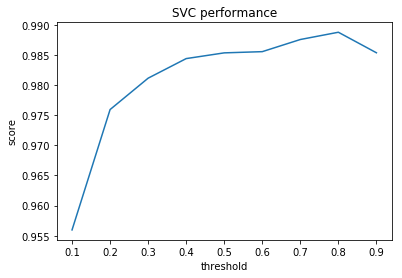

In [64]:
plt.plot(threshold,score_svc)
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('SVC performance')

threshold =0.8 is the best choice.

In [78]:
# evaluate on test data

X_test_predict_prob=model_svc_concat.predict_proba(X_test_feature)
X_test_predict_label=(X_test_predict_prob[:,1]>=0.8).astype(int)

print("the confusion matrix: \n", confusion_matrix(y_test,X_test_predict_label))
print("the accuracy score is ", accuracy_score(y_test,X_test_predict_label))
print("f-beta score is ", fbeta_score(y_test,X_test_predict_label,beta=0.5))
print('precision score is ', precision_score(y_test,X_test_predict_label))
print('recall score is ',recall_score(y_test,X_test_predict_label))

the confusion matrix: 
 [[243   9]
 [ 11 226]]
the accuracy score is  0.9591002044989775
f-beta score is  0.9600679694137637
precision score is  0.9617021276595744
recall score is  0.9535864978902954


The perfomance is almost the same as last section. Adding features doesn't improve the model. 

In this report, a spam filter for Youtube comments are presented. The best model in this report can achieve accuracy of ~0.95 to 0.96. Through analysis we‚Äôve seen some unique difficulties with classification of Youtube comments. Spams are semantically similar to ham. Comments are short which means a single strong indicating feature such as URL will mislead the model to think a ham containing URL is spam. In addition, Youtube is a social network which means new words are invented everyday and slang language is ubiquitous. Any new words the model has never seen will degrade the model performance. To further improve the model, we will need to iterate the training process so that the model will learn new words, we also need a larger dataset to train complicated models. In addition, as training set were larger and we were to see multiple account postings we can learn malicious account. One last comment, in this project the data size is pretty small thus SVM works very well. However as data size grow, SVM is very slow to train and logistic regression, random forest and naive bayes will be better.
